# New data creation notebook

## Import

In [1]:
import re
from string import punctuation

import emoji
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import textstat
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize
from tqdm import tqdm

## Load Data

In [2]:
posts_df = pd.read_csv('../data/all_posts-merged.csv')
comments_df = pd.read_csv('../data/all_comments-merged.csv')
users_df = pd.read_csv('../data/user_data-merged.csv')

In [3]:
display(posts_df.head(1))
display(comments_df.head(1))
display(users_df.head(1))

,subreddit,username,name,title,text,is_original_content,num_comments,score,upvote_ratio,date
0,AskReddit,elevate-digital,t3_1fxlnxv,"Guys with extremely loud vehicles, why do you ...",NaN,False,8421,20664,0.87,2024-10-06 17:20:58


,subreddit,username,body,post_title,score,num_replies,is_submitter,id,parent_id,stickied,date
0,AskReddit,thedudear,I used to own an insanely loud vehicle. A Pont...,"Guys with extremely loud vehicles, why do you ...",2045,6,False,lqpnfpr,t3_1fxlnxv,False,2024-10-07 01:35:59


,username,link_karma,comment_karma,account_age,is_verified
0,yakfsh1,19830.0,88232.0,1440.0,True


In [4]:
users_with_none_link_karma = users_df[users_df['link_karma'].isna()]

display(users_with_none_link_karma)

,username,link_karma,comment_karma,account_age,is_verified
248,chiskss_,NaN,NaN,NaN,NaN
402,Only_Lover8724,NaN,NaN,NaN,NaN
458,INeedARemoteJrCSJob,NaN,NaN,NaN,NaN
474,Bussy_Stank,NaN,NaN,NaN,NaN
489,MidnightEye02,NaN,NaN,NaN,NaN
...,...,...,...,...,...
383524,leostotch,NaN,NaN,NaN,NaN
383525,Mmmmmmm_Bacon,NaN,NaN,NaN,NaN
383526,vapemyashes,NaN,NaN,NaN,NaN
383527,brandonrez,NaN,NaN,NaN,NaN


In [5]:
comments_df = comments_df.dropna(subset=['body'])

In [6]:
posts_df.columns, comments_df.columns, users_df.columns

(Index(['subreddit', 'username', 'name', 'title', 'text', 'is_original_content',
        'num_comments', 'score', 'upvote_ratio', 'date'],
       dtype='object'),
 Index(['subreddit', 'username', 'body', 'post_title', 'score', 'num_replies',
        'is_submitter', 'id', 'parent_id', 'stickied', 'date'],
       dtype='object'),
 Index(['username', 'link_karma', 'comment_karma', 'account_age',
        'is_verified'],
       dtype='object'))

In [7]:
posts_df.shape, comments_df.shape, users_df.shape

((4405, 10), (783907, 11), (383595, 5))

### Vector

In [8]:
def clean_text(text):
    text = re.sub(r'[^\w\s]', '', text)
    text = text.lower()
    return text

def add_tfidf_vectors(comments_df):
    comments_df['cleaned_body'] = comments_df['body'].apply(clean_text)
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform(comments_df['cleaned_body'])
    tfidf_matrix = normalize(tfidf_matrix)
    tfidf_vectors = [vec for vec in tfidf_matrix]
    comments_df['vector'] = tfidf_vectors
    
    return comments_df

In [9]:
comments_df = add_tfidf_vectors(comments_df)

## Feature creation

In [10]:
new_features = pd.DataFrame(users_df['username'].copy())

### Cosine Similarity

In [11]:
def remove_zwj(comment):
    zwj = '\u200d'
    return comment.replace(zwj, '')


def is_weird_comment(comments):
    if all(len(comment) <= 1 or all(char in punctuation for char in comment) for comment in comments):
        return True
    if all(len(emoji.emoji_list(comment)) == 1 and emoji.emoji_list(comment)[0]['emoji'] == comment for comment in comments):
        return True
    if all(all(emoji.is_emoji(char) for char in comment) for comment in comments):
        return True
    if all(len(emoji.emoji_list(comment)) == len([char for char in comment if emoji.is_emoji(char)]) for comment in comments):
        return True
    if all(all(char in emoji.EMOJI_DATA for char in remove_zwj(comment)) for comment in comments):
        return True

    return False


def calculate_avg_cosine_similarity(comments_df):
    vectorizer = TfidfVectorizer()
    grouped_comments = comments_df.groupby('username')['body'].apply(list)
    avg_cosine_similarities = {}

    for username, comments in tqdm(grouped_comments.items(), desc="Processing cosine similarities of comments", total=len(grouped_comments)):
        
        if is_weird_comment(comments) and len(comments) > 1:
            avg_cosine_similarity = 1.0
        elif len(comments) > 1:
            tfidf_matrix = vectorizer.fit_transform(comments)
            cosine_sim_matrix = cosine_similarity(tfidf_matrix)
            avg_cosine_similarity = (cosine_sim_matrix.sum() - len(comments)) / (len(comments) * (len(comments) - 1))
        else:
            avg_cosine_similarity = None

        avg_cosine_similarities[username] = avg_cosine_similarity

    return avg_cosine_similarities


In [12]:
avg_cosine_similarities = calculate_avg_cosine_similarity(comments_df)
avg_cosine_similarities_df = pd.DataFrame(list(avg_cosine_similarities.items()), columns=['username', 'avg_cosine_similarity'])

display(avg_cosine_similarities_df.head())

Processing cosine similarities of comments: 100%|██████████| 313540/313540 [00:46<00:00, 6703.03it/s]


,username,avg_cosine_similarity
0,------------------GL,NaN
1,--------_----------_,1.0
2,--------rook,1.0
3,------____------,NaN
4,------____--------,NaN


In [13]:
new_features = new_features.merge(avg_cosine_similarities_df, on='username', how='left')

In [14]:
new_features['avg_cosine_similarity'].isna().sum() / len(new_features['avg_cosine_similarity'])

0.5367588211525176

### All Users similarity

In [15]:
def calculate_all_users_similarity(comments_df):
    # Sample 5000 random comments
    sampled_comments = comments_df['body'].sample(n=5000, random_state=42).tolist()

    # Initialize the vectorizer and fit it on the sampled comments
    vectorizer = TfidfVectorizer()
    sampled_matrix = vectorizer.fit_transform(sampled_comments)

    # Group comments by username
    grouped_comments = comments_df.groupby('username')['body'].apply(list)
    avg_cosine_similarities = {}

    for username, comments in tqdm(grouped_comments.items(), desc="Processing cosine similarities of comments", total=len(grouped_comments)):
        if len(comments) > 0:
            user_matrix = vectorizer.transform(comments)
            cosine_sim_matrix = cosine_similarity(user_matrix, sampled_matrix)
            avg_cosine_similarity = cosine_sim_matrix.mean(axis=1).mean()
        else:
            avg_cosine_similarity = None

        avg_cosine_similarities[username] = avg_cosine_similarity

    return avg_cosine_similarities

In [16]:
all_users_similarity = calculate_all_users_similarity(comments_df)
all_users_similarity_df = pd.DataFrame(list(all_users_similarity.items()), columns=['username', 'all_users_similarity'])

display(all_users_similarity_df.head())

Processing cosine similarities of comments: 100%|██████████| 313540/313540 [05:48<00:00, 898.82it/s]


,username,all_users_similarity
0,------------------GL,0.010012
1,--------_----------_,0.000725
2,--------rook,0.018314
3,------____------,0.057664
4,------____--------,0.001150


In [17]:
display(all_users_similarity_df.head())

,username,all_users_similarity
0,------------------GL,0.010012
1,--------_----------_,0.000725
2,--------rook,0.018314
3,------____------,0.057664
4,------____--------,0.001150


In [18]:
all_users_similarity_df.describe()

,all_users_similarity
count,313540.000000
mean,0.021583
std,0.013002
min,0.000000
25%,0.012461
50%,0.020600
75%,0.029347
max,0.096500


### AVG Length

In [19]:
def add_comment_length_metrics(df, users):
    new_df = pd.DataFrame(users.copy())
    grouped_comments = df.groupby('username')['body'].apply(list)
    
    avg_lengths = {}
    max_lengths = {}
    min_lengths = {}

    for username, comments in tqdm(grouped_comments.items(), desc="Processing comments length", total=len(grouped_comments)):
        comment_lengths = [len(comment) for comment in comments]
        avg_lengths[username] = sum(comment_lengths) / len(comment_lengths)
        max_lengths[username] = max(comment_lengths)
        min_lengths[username] = min(comment_lengths)

    new_df['avg_comment_length'] = df['username'].map(avg_lengths)
    new_df['max_comment_length'] = df['username'].map(max_lengths)
    new_df['min_comment_length'] = df['username'].map(min_lengths)

    return new_df

In [20]:
comments_length_df = add_comment_length_metrics(comments_df, users_df['username'])

Processing comments length: 100%|██████████| 313540/313540 [00:00<00:00, 921086.43it/s]


In [21]:
new_features = new_features.merge(comments_length_df, on='username', how='left')
display(new_features.head())

,username,avg_cosine_similarity,avg_comment_length,max_comment_length,min_comment_length
0,yakfsh1,1.0,382.000000,382.0,382.0
1,yakfsh1,1.0,53.000000,89.0,10.0
2,Tsquare43,1.0,62.000000,62.0,62.0
3,Tsquare43,1.0,18.000000,18.0,18.0
4,Tsquare43,1.0,40.666667,75.0,22.0


### Comment to post ratio

In [22]:
def add_comment_post_ratio(df, comments_df, posts_df):
    comments_per_user = comments_df.groupby('username').size().reset_index(name='num_comments')
    posts_per_user = posts_df.groupby('username').size().reset_index(name='num_posts')
    user_stats = comments_per_user.merge(posts_per_user, on='username', how='outer').fillna(0)
    user_stats['comment_post_ratio'] = user_stats.apply(
        lambda row: 0 if row['num_comments'] == 0 else (1 if row['num_posts'] == 0 else row['num_comments'] / row['num_posts']),
        axis=1
    )
    df = df.merge(user_stats[['username', 'comment_post_ratio']], on='username', how='left')
    
    return df

new_features = add_comment_post_ratio(new_features, comments_df, posts_df)

In [23]:
new_features.head()

,username,avg_cosine_similarity,avg_comment_length,max_comment_length,min_comment_length,comment_post_ratio
0,yakfsh1,1.0,382.000000,382.0,382.0,1.0
1,yakfsh1,1.0,53.000000,89.0,10.0,1.0
2,Tsquare43,1.0,62.000000,62.0,62.0,1.0
3,Tsquare43,1.0,18.000000,18.0,18.0,1.0
4,Tsquare43,1.0,40.666667,75.0,22.0,1.0


### Thread Average Depth

In [24]:
def add_average_thread_depth(df, comments_df):
    comments_df_copy = comments_df.copy()

    def calculate_depth(comment_id, parent_lookup):
        depth = 0
        while comment_id in parent_lookup and parent_lookup[comment_id].startswith("t1_"):
            parent_id = parent_lookup[comment_id]
            comment_id = parent_id[3:]
            depth += 1
        return depth

    comments_df_copy['depth'] = 0

    for post_title, group in comments_df_copy.groupby('post_title'):
        parent_lookup = dict(zip(group['id'], group['parent_id']))
        comments_df_copy.loc[group.index, 'depth'] = group['id'].apply(lambda x: calculate_depth(x, parent_lookup))
    
    avg_depth_per_user = comments_df_copy.groupby('username')['depth'].mean().reset_index(name='avg_thread_depth')
    df = df.merge(avg_depth_per_user, on='username', how='left')
    
    return df


In [25]:
new_features = add_average_thread_depth(new_features, comments_df)

display(new_features.head())

,username,avg_cosine_similarity,avg_comment_length,max_comment_length,min_comment_length,comment_post_ratio,avg_thread_depth
0,yakfsh1,1.0,382.000000,382.0,382.0,1.0,0.666667
1,yakfsh1,1.0,53.000000,89.0,10.0,1.0,0.666667
2,Tsquare43,1.0,62.000000,62.0,62.0,1.0,1.619048
3,Tsquare43,1.0,18.000000,18.0,18.0,1.0,1.619048
4,Tsquare43,1.0,40.666667,75.0,22.0,1.0,1.619048


### Parent-child similarity

In [26]:
def add_average_similarity(df, comments_df):
    comments_df_copy = comments_df.copy()

    def calculate_average_similarity(comment_id, parent_lookup, comment_vectors):
        similarities = []
        current_id = comment_id
        
        while current_id in parent_lookup and parent_lookup[current_id].startswith("t1_"):
            parent_id = parent_lookup[current_id]
            current_id = parent_id[3:]
            if current_id in comment_vectors:
                similarity = cosine_similarity(comment_vectors[comment_id], comment_vectors[current_id])[0, 0]
                similarities.append(similarity)
        
        if similarities:
            return sum(similarities) / len(similarities)
        else:
            return 0

    comments_df_copy['similarity'] = 0.0

    for post_title, group in tqdm(comments_df_copy.groupby('post_title'), desc="Processing parent child similarity"):
        parent_lookup = dict(zip(group['id'], group['parent_id']))
        comment_vectors = dict(zip(group['id'], group['vector']))
        comments_df_copy.loc[group.index, 'similarity'] = group['id'].apply(
            lambda x: calculate_average_similarity(x, parent_lookup, comment_vectors)
        )

    user_similarity = comments_df_copy.groupby('username')['similarity'].mean().reset_index()
    user_similarity.columns = ['username', 'average_similarity']
    df = df.merge(user_similarity, on='username', how='left')
    
    return df

In [27]:
new_features = add_average_similarity(new_features, comments_df)
display(new_features.head())

Processing parent child similarity: 100%|██████████| 4373/4373 [07:04<00:00, 10.29it/s]


,username,avg_cosine_similarity,avg_comment_length,max_comment_length,min_comment_length,comment_post_ratio,avg_thread_depth,average_similarity
0,yakfsh1,1.0,382.000000,382.0,382.0,1.0,0.666667,0.030395
1,yakfsh1,1.0,53.000000,89.0,10.0,1.0,0.666667,0.030395
2,Tsquare43,1.0,62.000000,62.0,62.0,1.0,1.619048,0.037736
3,Tsquare43,1.0,18.000000,18.0,18.0,1.0,1.619048,0.037736
4,Tsquare43,1.0,40.666667,75.0,22.0,1.0,1.619048,0.037736


In [28]:
new_features['average_similarity'].describe()

count    532307.000000
mean          0.045801
std           0.065159
min           0.000000
25%           0.000000
50%           0.023113
75%           0.070176
max           1.000000
Name: average_similarity, dtype: float64

### Type-Token Ratio - This is a basic measure of lexical diversity.

In [29]:
def calculate_ttr(text):
    tokens = word_tokenize(text)
    num_tokens = len(tokens)
    num_types = len(set(tokens))
    if num_tokens == 0:
        return 0
    return num_types / num_tokens

def add_average_ttr(df, comments_df):
    comments_df['ttr'] = comments_df['cleaned_body'].apply(calculate_ttr)
    avg_ttr_per_user = comments_df.groupby('username')['ttr'].mean().reset_index(name='avg_ttr')
    df = df.merge(avg_ttr_per_user, on='username', how='left')
    
    return df

In [30]:
new_features = add_average_ttr(new_features, comments_df)

display(new_features.head())

,username,avg_cosine_similarity,avg_comment_length,max_comment_length,min_comment_length,comment_post_ratio,avg_thread_depth,average_similarity,avg_ttr
0,yakfsh1,1.0,382.000000,382.0,382.0,1.0,0.666667,0.030395,0.955981
1,yakfsh1,1.0,53.000000,89.0,10.0,1.0,0.666667,0.030395,0.955981
2,Tsquare43,1.0,62.000000,62.0,62.0,1.0,1.619048,0.037736,0.955845
3,Tsquare43,1.0,18.000000,18.0,18.0,1.0,1.619048,0.037736,0.955845
4,Tsquare43,1.0,40.666667,75.0,22.0,1.0,1.619048,0.037736,0.955845


### Language Readability

In [31]:
def calculate_flesch_kincaid_grade(text):
    return textstat.flesch_kincaid_grade(text)

def add_average_flesch_kincaid_grade(df, comments_df):
    comments_df['flesch_kincaid_grade'] = comments_df['cleaned_body'].apply(calculate_flesch_kincaid_grade)
    avg_grade_per_user = comments_df.groupby('username')['flesch_kincaid_grade'].mean().reset_index(name='avg_flesch_kincaid_grade')
    df = df.merge(avg_grade_per_user, on='username', how='left')
    
    return df


In [32]:
new_features = add_average_flesch_kincaid_grade(new_features, comments_df)

display(new_features.head())

,username,avg_cosine_similarity,avg_comment_length,max_comment_length,min_comment_length,comment_post_ratio,avg_thread_depth,average_similarity,avg_ttr,avg_flesch_kincaid_grade
0,yakfsh1,1.0,382.000000,382.0,382.0,1.0,0.666667,0.030395,0.955981,9.20000
1,yakfsh1,1.0,53.000000,89.0,10.0,1.0,0.666667,0.030395,0.955981,9.20000
2,Tsquare43,1.0,62.000000,62.0,62.0,1.0,1.619048,0.037736,0.955845,7.07619
3,Tsquare43,1.0,18.000000,18.0,18.0,1.0,1.619048,0.037736,0.955845,7.07619
4,Tsquare43,1.0,40.666667,75.0,22.0,1.0,1.619048,0.037736,0.955845,7.07619


### Overlapping N-grams

In [33]:
def get_ngrams(text, n=2):
    vectorizer = CountVectorizer(ngram_range=(n, n))
    analyzer = vectorizer.build_analyzer()
    return set(analyzer(text))

def calculate_overlap(comments, n=2):
    if len(comments) < 2:
        return 0.0
    
    all_ngrams = [get_ngrams(comment, n) for comment in comments]
    overlap_count = 0
    total_count = 0
    
    for i in range(len(all_ngrams)):
        for j in range(i + 1, len(all_ngrams)):
            overlap_count += len(all_ngrams[i].intersection(all_ngrams[j]))
            total_count += len(all_ngrams[i].union(all_ngrams[j]))
    
    if total_count == 0:
        return 0.0
    
    return overlap_count / total_count

def add_ngram_overlap(df, comments_df, n=2):
    grouped_comments = comments_df.groupby('username')['cleaned_body'].apply(list)
    
    overlap_ratios = {}
    
    for username, comments in tqdm(grouped_comments.items(), desc="Calculating n-gram overlap", total=len(grouped_comments)):
        overlap_ratios[username] = calculate_overlap(comments, n)
    
    overlap_df = pd.DataFrame(list(overlap_ratios.items()), columns=['username', 'ngram_overlap'])
    
    df = df.merge(overlap_df, on='username', how='left')
    
    return df

In [34]:
new_features = add_ngram_overlap(new_features, comments_df, n=2)

display(new_features.head())

Calculating n-gram overlap: 100%|██████████| 313540/313540 [00:09<00:00, 32455.80it/s]


,username,avg_cosine_similarity,avg_comment_length,max_comment_length,min_comment_length,comment_post_ratio,avg_thread_depth,average_similarity,avg_ttr,avg_flesch_kincaid_grade,ngram_overlap
0,yakfsh1,1.0,382.000000,382.0,382.0,1.0,0.666667,0.030395,0.955981,9.20000,0.002070
1,yakfsh1,1.0,53.000000,89.0,10.0,1.0,0.666667,0.030395,0.955981,9.20000,0.002070
2,Tsquare43,1.0,62.000000,62.0,62.0,1.0,1.619048,0.037736,0.955845,7.07619,0.000198
3,Tsquare43,1.0,18.000000,18.0,18.0,1.0,1.619048,0.037736,0.955845,7.07619,0.000198
4,Tsquare43,1.0,40.666667,75.0,22.0,1.0,1.619048,0.037736,0.955845,7.07619,0.000198


### ----------------

In [35]:
comments_df.columns

Index(['subreddit', 'username', 'body', 'post_title', 'score', 'num_replies',
       'is_submitter', 'id', 'parent_id', 'stickied', 'date', 'cleaned_body',
       'vector', 'ttr', 'flesch_kincaid_grade'],
      dtype='object')

In [36]:
labels = pd.read_csv('../data/labels.csv')

In [37]:
def average_score(df, comments_df):
    comments_df['score'] = comments_df['score'].fillna(0)
    avg_score_per_user = comments_df.groupby('username')['score'].mean().reset_index(name='avg_score')
    df = df.merge(avg_score_per_user, on='username', how='left')
    
    return df

def average_num_replies(df, comments_df):
    comments_df['num_replies'] = comments_df['num_replies'].fillna(0)
    avg_num_replies_per_user = comments_df.groupby('username')['num_replies'].mean().reset_index(name='avg_num_replies')
    df = df.merge(avg_num_replies_per_user, on='username', how='left')
    
    return df

def average_stickied(df, comments_df):
    comments_df['stickied'] = comments_df['stickied'].fillna(False)
    avg_stickied_per_user = comments_df.groupby('username')['stickied'].mean().reset_index(name='avg_stickied')
    df = df.merge(avg_stickied_per_user, on='username', how='left')
    
    return df



In [38]:
new_features = average_score(new_features, comments_df)
new_features = average_num_replies(new_features, comments_df)
# new_features = average_stickied(new_features, comments_df)
display(new_features.head())

,username,avg_cosine_similarity,avg_comment_length,max_comment_length,min_comment_length,comment_post_ratio,avg_thread_depth,average_similarity,avg_ttr,avg_flesch_kincaid_grade,ngram_overlap,avg_score,avg_num_replies
0,yakfsh1,1.0,382.000000,382.0,382.0,1.0,0.666667,0.030395,0.955981,9.20000,0.002070,1173.666667,2.111111
1,yakfsh1,1.0,53.000000,89.0,10.0,1.0,0.666667,0.030395,0.955981,9.20000,0.002070,1173.666667,2.111111
2,Tsquare43,1.0,62.000000,62.0,62.0,1.0,1.619048,0.037736,0.955845,7.07619,0.000198,26.571429,0.333333
3,Tsquare43,1.0,18.000000,18.0,18.0,1.0,1.619048,0.037736,0.955845,7.07619,0.000198,26.571429,0.333333
4,Tsquare43,1.0,40.666667,75.0,22.0,1.0,1.619048,0.037736,0.955845,7.07619,0.000198,26.571429,0.333333


In [39]:
new_features = new_features.drop_duplicates(subset=['username'])

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_feature_distributions(X_train, y_train, class_column='is_bot'):
    # Ensure y_train is a 1-dimensional array
    y_train = y_train[class_column].values.flatten()
    
    # Combine X_train and y_train into a single DataFrame for easier plotting
    X_train = X_train.drop(columns=['username'])
    data = X_train.copy()
    data[class_column] = y_train
    
    # Plot the distribution of each feature
    for feature in X_train.columns:
        try:
            plt.figure(figsize=(10, 6))
            sns.histplot(data=data, x=feature, hue=class_column, kde=True, bins=20, palette='viridis')
            plt.title(f'Distribution of {feature} by {class_column}')
            plt.xlabel(feature)
            plt.ylabel('Frequency')
            plt.legend(title=class_column)
            plt.show()
        except Exception as e:
            print(f"Error plotting {feature}: {e}")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


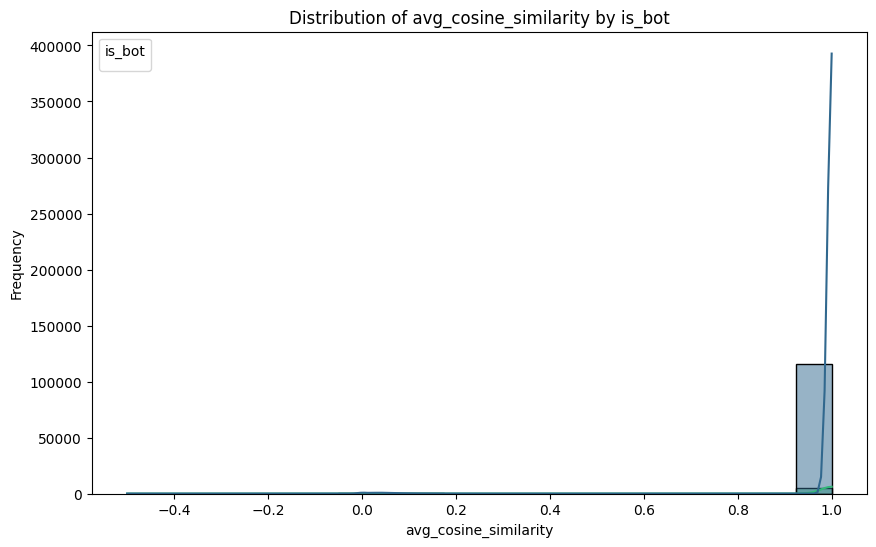

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


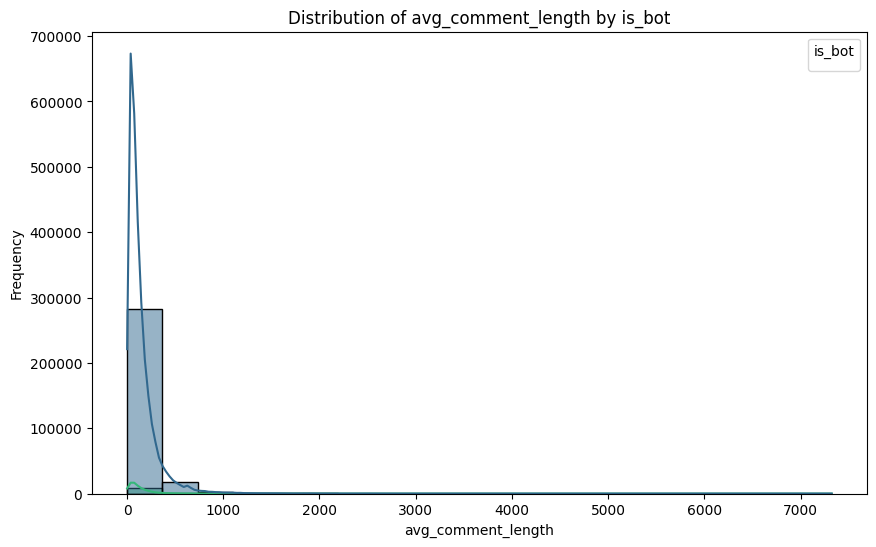

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


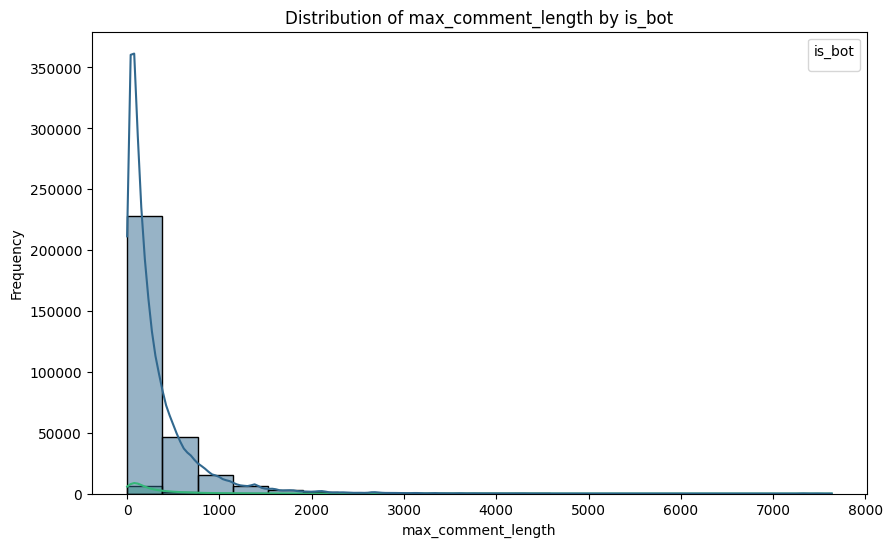

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


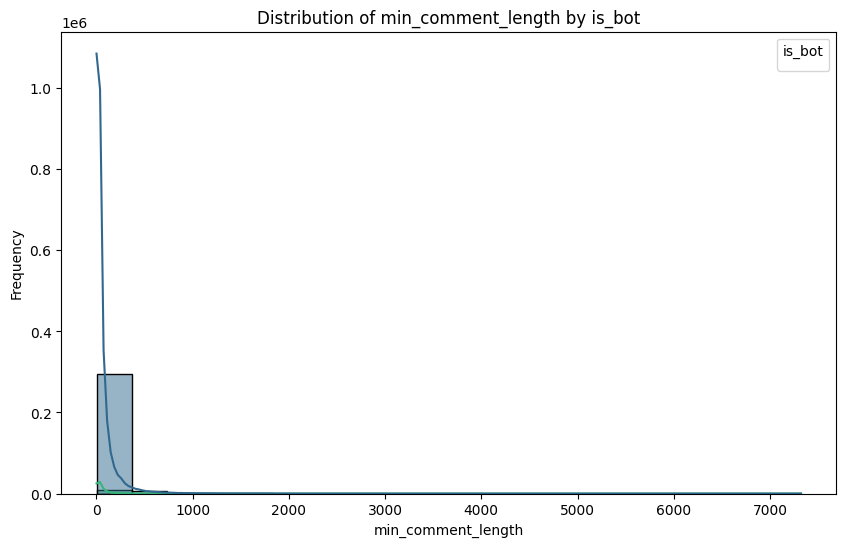

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


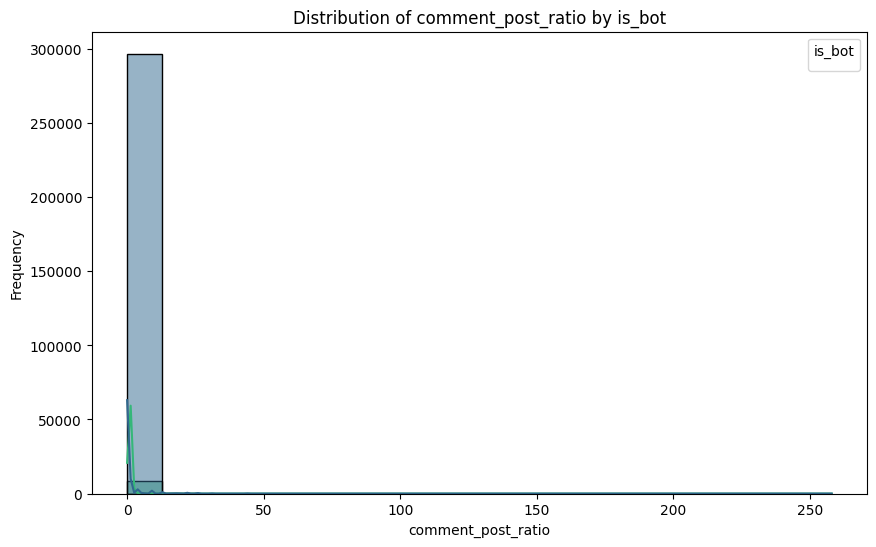

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


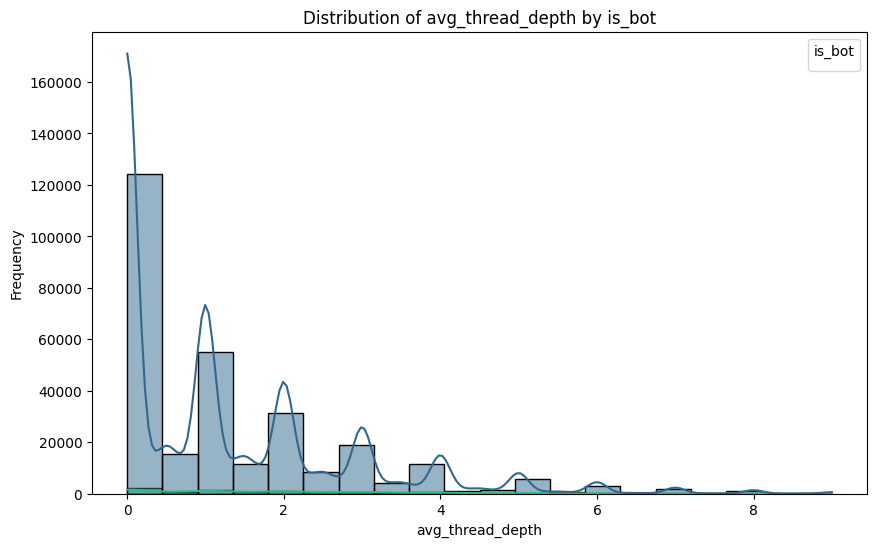

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


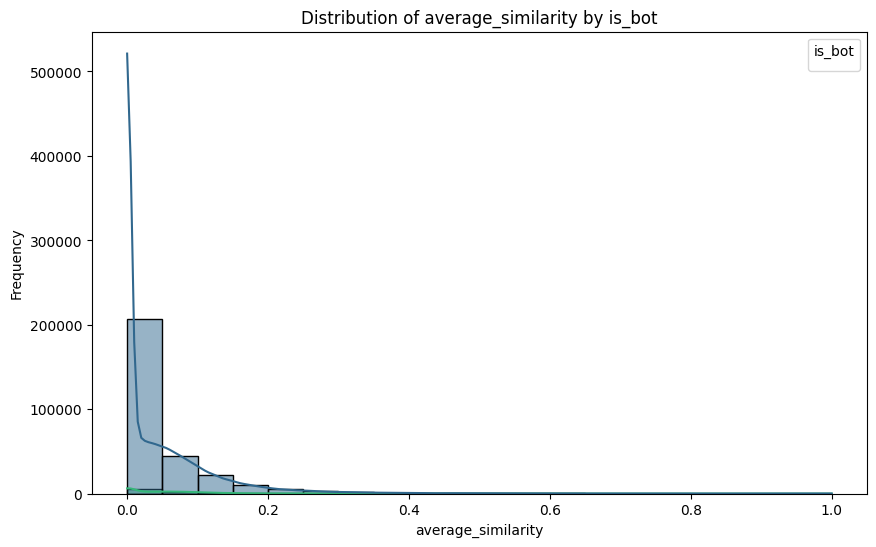

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


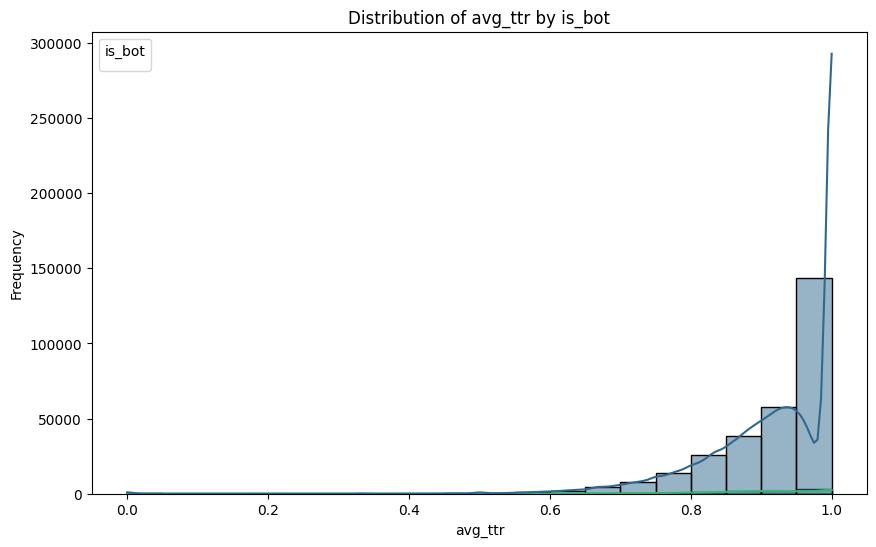

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


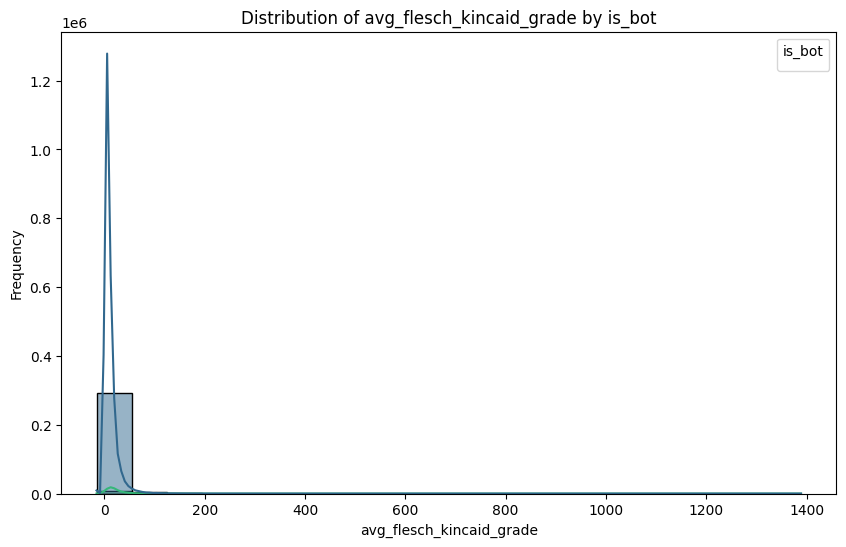

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


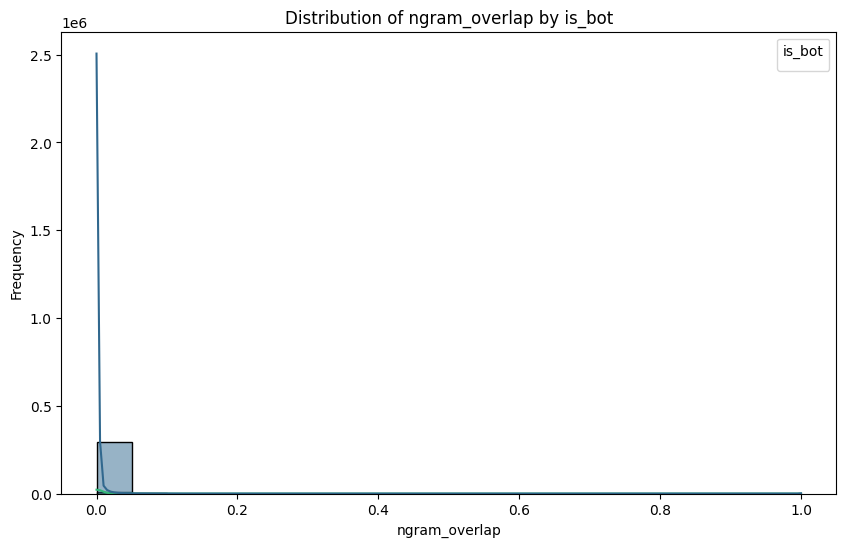

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


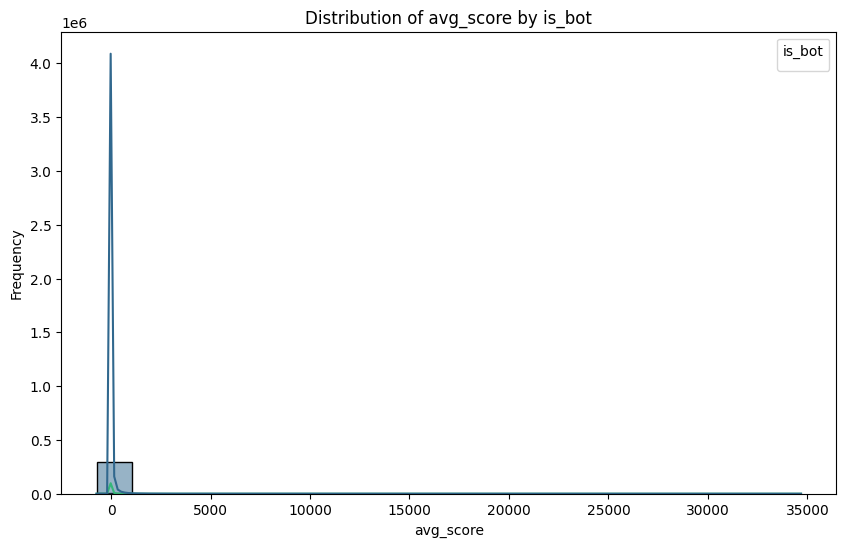

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


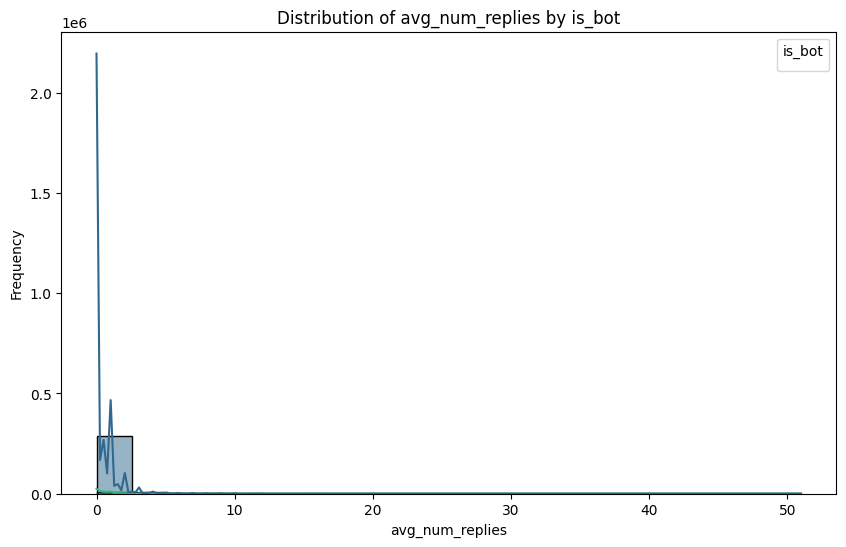

In [41]:
plot_feature_distributions(new_features, labels)

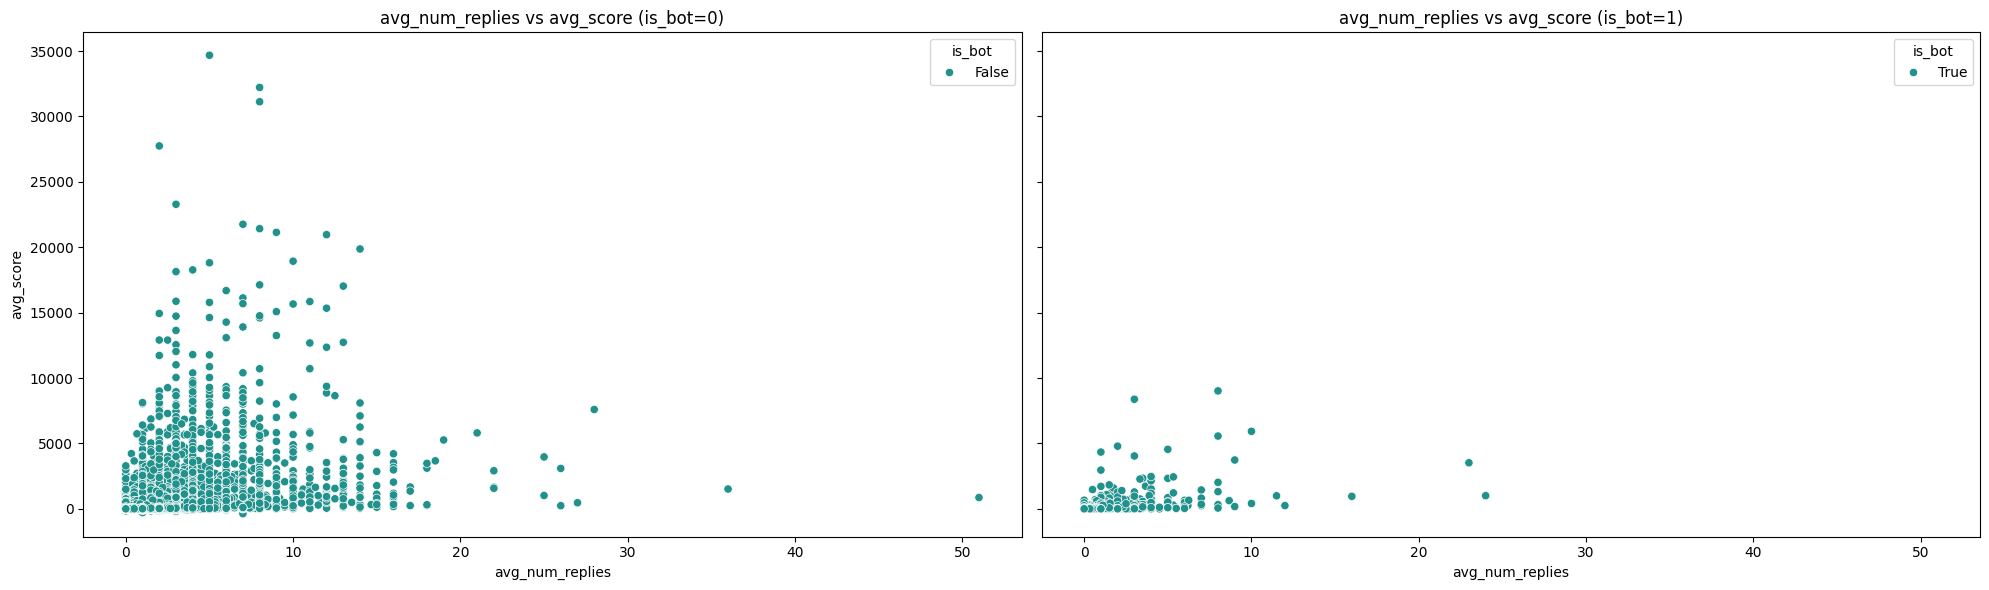

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_avg_num_replies_vs_avg_score_with_labels(data, class_column='is_bot'):
    fig, axes = plt.subplots(1, 2, figsize=(20, 6), sharex=True, sharey=True)
    
    # Scatter plot for is_bot = 0
    sns.scatterplot(data=data[data[class_column] == 0], x='avg_num_replies', y='avg_score', hue=class_column, palette='viridis', ax=axes[0])
    axes[0].set_title('avg_num_replies vs avg_score (is_bot=0)')
    axes[0].set_xlabel('avg_num_replies')
    axes[0].set_ylabel('avg_score')
    axes[0].legend(title=class_column)
    
    # Scatter plot for is_bot = 1
    sns.scatterplot(data=data[data[class_column] == 1], x='avg_num_replies', y='avg_score', hue=class_column, palette='viridis', ax=axes[1])
    axes[1].set_title('avg_num_replies vs avg_score (is_bot=1)')
    axes[1].set_xlabel('avg_num_replies')
    axes[1].set_ylabel('avg_score')
    axes[1].legend(title=class_column)
    
    plt.tight_layout()
    plt.show()

# Example usage:
# Assuming new_features is your DataFrame and labels is your target DataFrame
data = new_features.copy()
data['is_bot'] = labels['is_bot']
plot_avg_num_replies_vs_avg_score_with_labels(data)

In [43]:
new_features.columns

Index(['username', 'avg_cosine_similarity', 'avg_comment_length',
       'max_comment_length', 'min_comment_length', 'comment_post_ratio',
       'avg_thread_depth', 'average_similarity', 'avg_ttr',
       'avg_flesch_kincaid_grade', 'ngram_overlap', 'avg_score',
       'avg_num_replies'],
      dtype='object')

In [44]:
features = pd.read_csv('../data/features.csv')

In [45]:
merged_features = features.merge(new_features[['username', 'avg_score',
       'avg_num_replies']], on='username', how='left')

In [46]:
merged_features.columns

Index(['username', 'link_karma', 'comment_karma', 'account_age', 'is_verified',
       'avg_cosine_similarity', 'all_users_similarity', 'avg_comment_length',
       'max_comment_length', 'min_comment_length', 'comment_post_ratio',
       'avg_thread_depth', 'parent_child_similarity', 'avg_ttr',
       'avg_flesch_kincaid_grade', 'ngram_overlap', 'avg_score',
       'avg_num_replies'],
      dtype='object')

In [47]:
# save
merged_features.to_csv('../data/features5.csv', index=False)